In [1]:
# Avoid JAX from using up all the GPU memory
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
import time

import numpy as np

import jax
import jax.random
import jax.extend
import jax.numpy as jnp

from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm  # Colormaps

import seaborn as sns

sns.set_style('darkgrid')

In [3]:
print(f"{jax.__version__=}")
backend = str(jax.extend.backend.get_backend().platform)
print(f"JAX backend: {backend}")

jax.__version__='0.4.35'
JAX backend: gpu


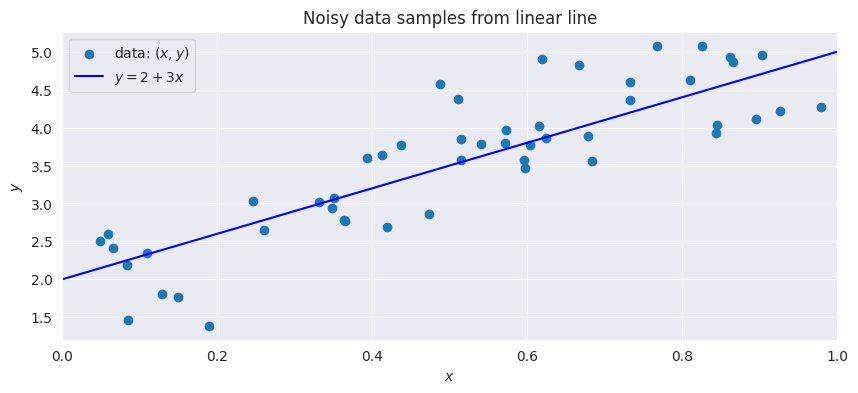

In [4]:
# Define the data
np.random.seed(4)
# Generate random data
n = 50 # Number of samples
# Underlying linear relation
m = 3  # slope
b = 2  # bias
# Noise
e_std = 0.5  # Standard deviation of the noise
err = e_std * np.random.randn(n)  # Noise
# Features and output
x = np.random.uniform(0, 1, n)  # Independent variable x
y = x * m + b + err  # Dependent variable
# Stack X with ones to be fitted by vectorized methods
#  such as OLS and gradient descent
X = np.vstack((np.ones_like(x), x)).T

# Show data
plt.figure(figsize=(10, 4))
plt.scatter(x, y, label='data: $(x,y)$')
plt.plot(
    [0, 1], [b, m+b], 'b-', 
    label=f'$y = {b:.0f} + {m:.0f} x$'
)
plt.xlim((0, 1))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Noisy data samples from linear line')
plt.legend()
plt.show()

# Simple linear regrssion in jax

Estimated intercept: 1.9317
Estimated slope: 3.1743


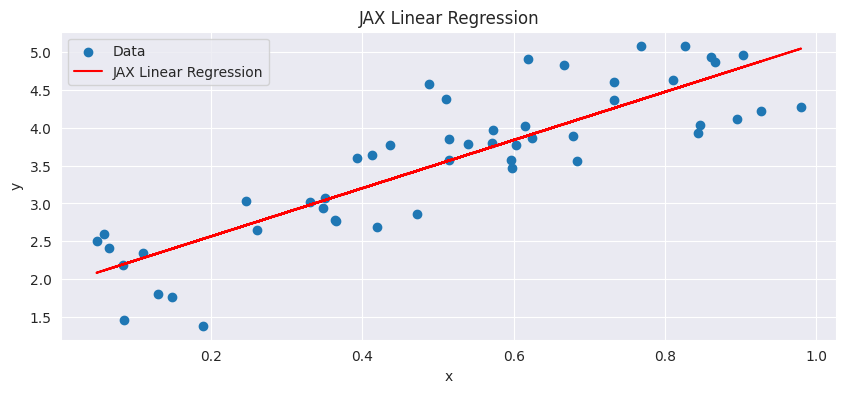

In [5]:
# Perform linear regression using JAX

# Define the model
def linear_model(params, x):
    return params[0] + params[1] * x

# Define the loss function (Mean Squared Error)
def mse_loss(params, x, y):
    predictions = linear_model(params, x)
    return jnp.mean((y - predictions) ** 2)

# Gradient of the loss function
grad_mse_loss = jax.jit(jax.grad(mse_loss))

# Initialize parameters
initial_params = jnp.array([0.0, 0.0])

# Optimization loop
learning_rate = 0.1
num_iterations = 1000

params = initial_params
for _ in range(num_iterations):
    grads = grad_mse_loss(params, x, y)
    params = params - learning_rate * grads

# Print results
print(f"Estimated intercept: {params[0]:.4f}")
print(f"Estimated slope: {params[1]:.4f}")

# Plot the results
plt.figure(figsize=(10, 4))
plt.scatter(x, y, label='Data')
plt.plot(x, linear_model(params, x), 'r-', label='JAX Linear Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.title('JAX Linear Regression')
plt.legend()
plt.show()


# Lagavin Monte Carlo

In [16]:
# Define the model
def linear_model(params, x):
    return params[0] + params[1] * x


# Define the loss function (Mean Squared Error)
def mse_loss(params, x, y):
    predictions = linear_model(params, x)
    return jnp.mean((y - predictions) ** 2)



# Define the Lagavin Monte Carlo sampler
def lagavin_monte_carlo(grad_log_posterior, initial_params, num_samples, step_size, num_steps, rng_key=jax.random.PRNGKey(0)):
    params = initial_params
    samples = jnp.zeros((num_samples,) + initial_params.shape)
    
    for i in tqdm(range(num_samples), desc="Sampling", unit="sample"):
        for _ in range(num_steps):
            new_key, rng_key = jax.random.split(rng_key)
            grad = grad_log_posterior(params)
            brownian_noise = jnp.sqrt(2 * step_size) * jax.random.normal(key=new_key, shape=params.shape)
            params = params - step_size * grad + brownian_noise
        
        samples = samples.at[i].set(params)
    
    return samples

# # Define the log posterior (assuming Gaussian prior and likelihood)
# def log_posterior(params, x, y, prior_std):
#     log_likelihood = -0.5 * jnp.sum((y - linear_model(params, x))**2)
#     log_prior = -0.5 * jnp.sum((params / prior_std)**2)
#     return log_likelihood + log_prior


# Gradient of the log posterior
grad_log_posterior = jax.jit(jax.grad(lambda params: mse_loss(params, x, y)))

# Run Lagavin Monte Carlo
num_samples = 5000
step_size = 0.1
num_steps = 10
samples = lagavin_monte_carlo(grad_log_posterior, initial_params, num_samples, step_size, num_steps)
print(f"{samples.shape=}")

# Calculate mean and credible intervals
mean_params = jnp.mean(samples, axis=0)
print(f"{mean_params.shape=}")
print(f"{mean_params=}")



Sampling:   0%|          | 0/5000 [00:00<?, ?sample/s]

samples.shape=(5000, 2)
mean_params.shape=(2,)
mean_params=Array([1.8710421, 3.2892818], dtype=float32)


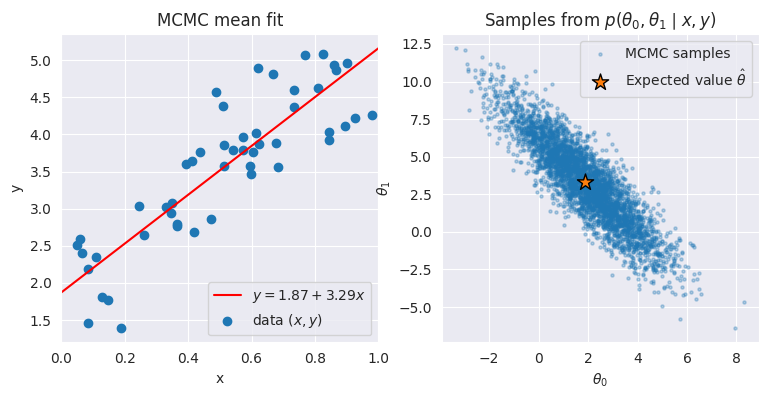

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4), dpi=100)
ax1.plot(
    [0, 1], [linear_model(mean_params, x=0), linear_model(mean_params, x=1)], 'r-', 
    label=f'$y = {mean_params[0]:.2f} + {mean_params[1]:.2f} x$')
ax1.scatter(x, y, label='data $(x,y)$')
ax1.legend()
ax1.set_title('MCMC mean fit')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim((0, 1))

ax2.scatter(
    samples[1000:,0], samples[1000:,1], 
    alpha=0.3, s=5, label='MCMC samples')
ax2.scatter(
    [mean_params[0]], [mean_params[1]], label='Expected value $\\hat{\\theta}$',
    s=150, marker='*', edgecolors='k')
ax2.set_title('Samples from $p(\\theta_0, \\theta_1 \\mid x,y)$')
ax2.set_xlabel('$\\theta_0$')
ax2.set_ylabel('$\\theta_1$')
ax2.legend()
plt.show()
